<a href="https://colab.research.google.com/github/jazu1412/LOW_CODE_AUTOML_AUTOGLUON/blob/master/ieee_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IEEE Fraud Detection with AutoGluon

This notebook demonstrates how to use AutoGluon for the IEEE Fraud Detection Kaggle competition.

In [ ]:
import autogluon as ag
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Install required packages
!pip install autogluon pandas numpy scikit-learn matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requireme

## Data Download from Kaggle

In [ ]:
!pip install kaggle

In [3]:
cd sample_data/ieee-fraud-detection/

/content/sample_data/ieee-fraud-detection


In [4]:
pwd

'/content/sample_data/ieee-fraud-detection'

In [5]:
!mkdir -p ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
pwd

'/content/sample_data/ieee-fraud-detection'

## Data Loading and Exploration

In [20]:
# Load the data
train_data = pd.read_csv('train_transaction.csv')
test_data = pd.read_csv('test_transaction.csv')

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Separate features and target
X = train_data.drop('isFraud', axis=1)
y = train_data['isFraud']

# Display basic information about the dataset
train_data.info()

Train data shape: (49481, 394)
Test data shape: (49919, 393)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49481 entries, 0 to 49480
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 148.7+ MB


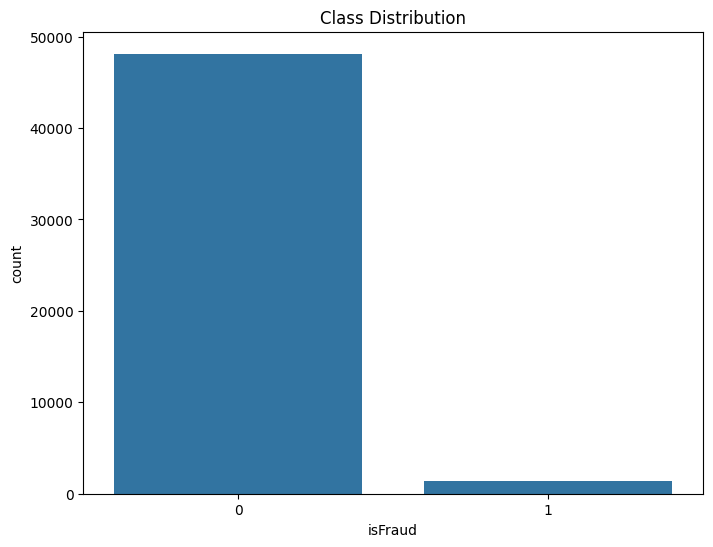

Fraud transactions: 1352
Non-fraud transactions: 48129
Fraud ratio: 2.73%


In [21]:
# Check class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='isFraud', data=train_data)
plt.title('Class Distribution')
plt.show()

print(f"Fraud transactions: {train_data['isFraud'].sum()}")
print(f"Non-fraud transactions: {len(train_data) - train_data['isFraud'].sum()}")
print(f"Fraud ratio: {train_data['isFraud'].mean():.2%}")

## Data Preprocessing and Feature Engineering

No path specified. Models will be saved in: "AutogluonModels/ag-20240913_013044"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.33 GB / 12.67 GB (65.7%)
Disk Space Avail:   70.10 GB / 112.64 GB (62.2%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to False. Reason: Skip dynamic_stacking when use_bag_holdout is enabled. (use_bag_holdout=True)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=5, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 3600s
AutoGluon will save models to "AutogluonModels/ag-20240913_013044"
Train Data Rows:    39584
Train Data Columns: 29
Tuning Data Rows:    9897
Tuning Data Columns: 29
Label Column:       isFraud
AutoGluon infers your prediction

Validation performance: {'roc_auc': 0.8869068091671187, 'accuracy': 0.9786804082045064, 'balanced_accuracy': 0.6290583197719377, 'mcc': 0.46669547065894684, 'f1': 0.39886039886039887, 'precision': 0.8641975308641975, 'recall': 0.25925925925925924}


	56.18s	= Expected runtime (11.24s per shuffle set)
	54.77s	= Actual runtime (Completed 5 of 5 shuffle sets)


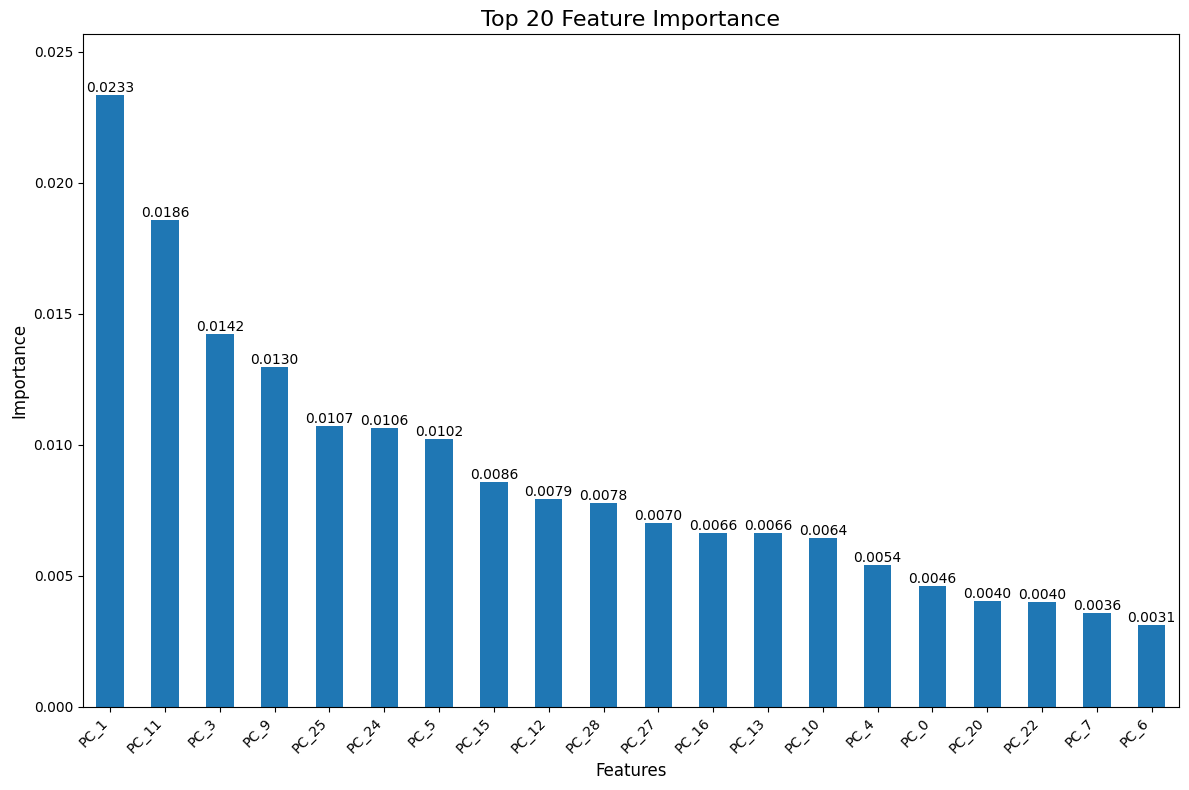

In [22]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ... (keep your existing imports)

def preprocess_data(df, is_test=False):
    # Handle missing values
    df = df.fillna(-999)

    # Create new features
    df['TransactionAmt_to_mean_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_mean_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('mean')
    df['TransactionAmt_to_std_card1'] = df['TransactionAmt'] / df.groupby(['card1'])['TransactionAmt'].transform('std')
    df['TransactionAmt_to_std_card4'] = df['TransactionAmt'] / df.groupby(['card4'])['TransactionAmt'].transform('std')

    # Feature interactions
    df['addr1_addr2'] = df['addr1'].astype(str) + '_' + df['addr2'].astype(str)
    df['card1_addr1'] = df['card1'].astype(str) + '_' + df['addr1'].astype(str)

    # Convert categorical columns to numerical
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = pd.factorize(df[col])[0]

    # Handle infinity and very large values
    for col in df.select_dtypes(include=np.number).columns:
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        df[col] = df[col].fillna(df[col].mean())

    # Remove 'TransactionID' and 'isFraud' (if present) for consistent feature set
    if 'TransactionID' in df.columns:
        df = df.drop('TransactionID', axis=1)
    if not is_test and 'isFraud' in df.columns:
        df = df.drop('isFraud', axis=1)

    return df

# Load the data
train_data = pd.read_csv('train_transaction.csv')
test_data = pd.read_csv('test_transaction.csv')

# Separate features and target for training data
y = train_data['isFraud']
X = preprocess_data(train_data)

# Preprocess test data
test_data_processed = preprocess_data(test_data, is_test=True)

# Store TransactionID separately for later use
test_transaction_ids = test_data['TransactionID']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(test_data_processed)

# Apply PCA
pca = PCA(n_components=0.95)  # Preserve 95% of variance
X_pca = pca.fit_transform(X_scaled)
test_pca = pca.transform(test_scaled)

# Convert back to dataframe
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC_{i}' for i in range(X_pca.shape[1])])
test_pca_df = pd.DataFrame(test_pca, columns=[f'PC_{i}' for i in range(test_pca.shape[1])])

# Add the target variable back to the training data
X_pca_df['isFraud'] = y

# Split the data
train, valid = train_test_split(X_pca_df, test_size=0.2, random_state=42, stratify=X_pca_df['isFraud'])

# Define the label column
label_column = 'isFraud'

# Train the model
predictor = TabularPredictor(label=label_column, eval_metric='roc_auc').fit(
    train,
    tuning_data=valid,
    time_limit=3600,
    presets='best_quality',
    num_stack_levels=1,
    num_bag_folds=5,
    use_bag_holdout=True,
    hyperparameters={'GBM': {'num_gpus': 1}}
)

# Evaluate the model
performance = predictor.evaluate(valid)
print(f'Validation performance: {performance}')

# Feature importance
feature_importance = predictor.feature_importance(valid)

# Sort features by importance
feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)

# Select top N features (e.g., top 20)
top_n = 20
feature_importance_top = feature_importance_sorted.head(top_n)

# Create the plot
plt.figure(figsize=(12, 8))
ax = feature_importance_top['importance'].plot(kind='bar')

# Customize the plot
plt.title('Top 20 Feature Importance', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Adjust y-axis to start from 0 and end slightly above the maximum importance
y_max = feature_importance_top['importance'].max()
plt.ylim(0, y_max * 1.1)

# Add value labels on top of each bar
for i, v in enumerate(feature_importance_top['importance']):
    ax.text(i, v, f'{v:.4f}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.show()




In [24]:
test_predictions = predictor.predict_proba(test_pca_df)

# Check if the predictions are returned as a DataFrame
if isinstance(test_predictions, pd.DataFrame):
    # If it's a DataFrame, we assume the second column is the positive class probability
    test_predictions = test_predictions.iloc[:, 1]
else:
    # If it's not a DataFrame (e.g., numpy array), we take the second column
    test_predictions = test_predictions[:, 1]

## Submission File

In [25]:
# Create submission file
submission = pd.DataFrame({'TransactionID': test_transaction_ids, 'isFraud': test_predictions})
submission.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
